In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2024-01-31 14:01:22.407121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size=256
batch_size=32
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 16011 files belonging to 9 classes.


In [3]:
class_names=dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [4]:
len(dataset)

501

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[6 6 3 1 1 4 4 4 3 3 4 3 4 0 3 1 1 4 1 7 6 0 6 7 5 7 3 5 6 4 4 2]


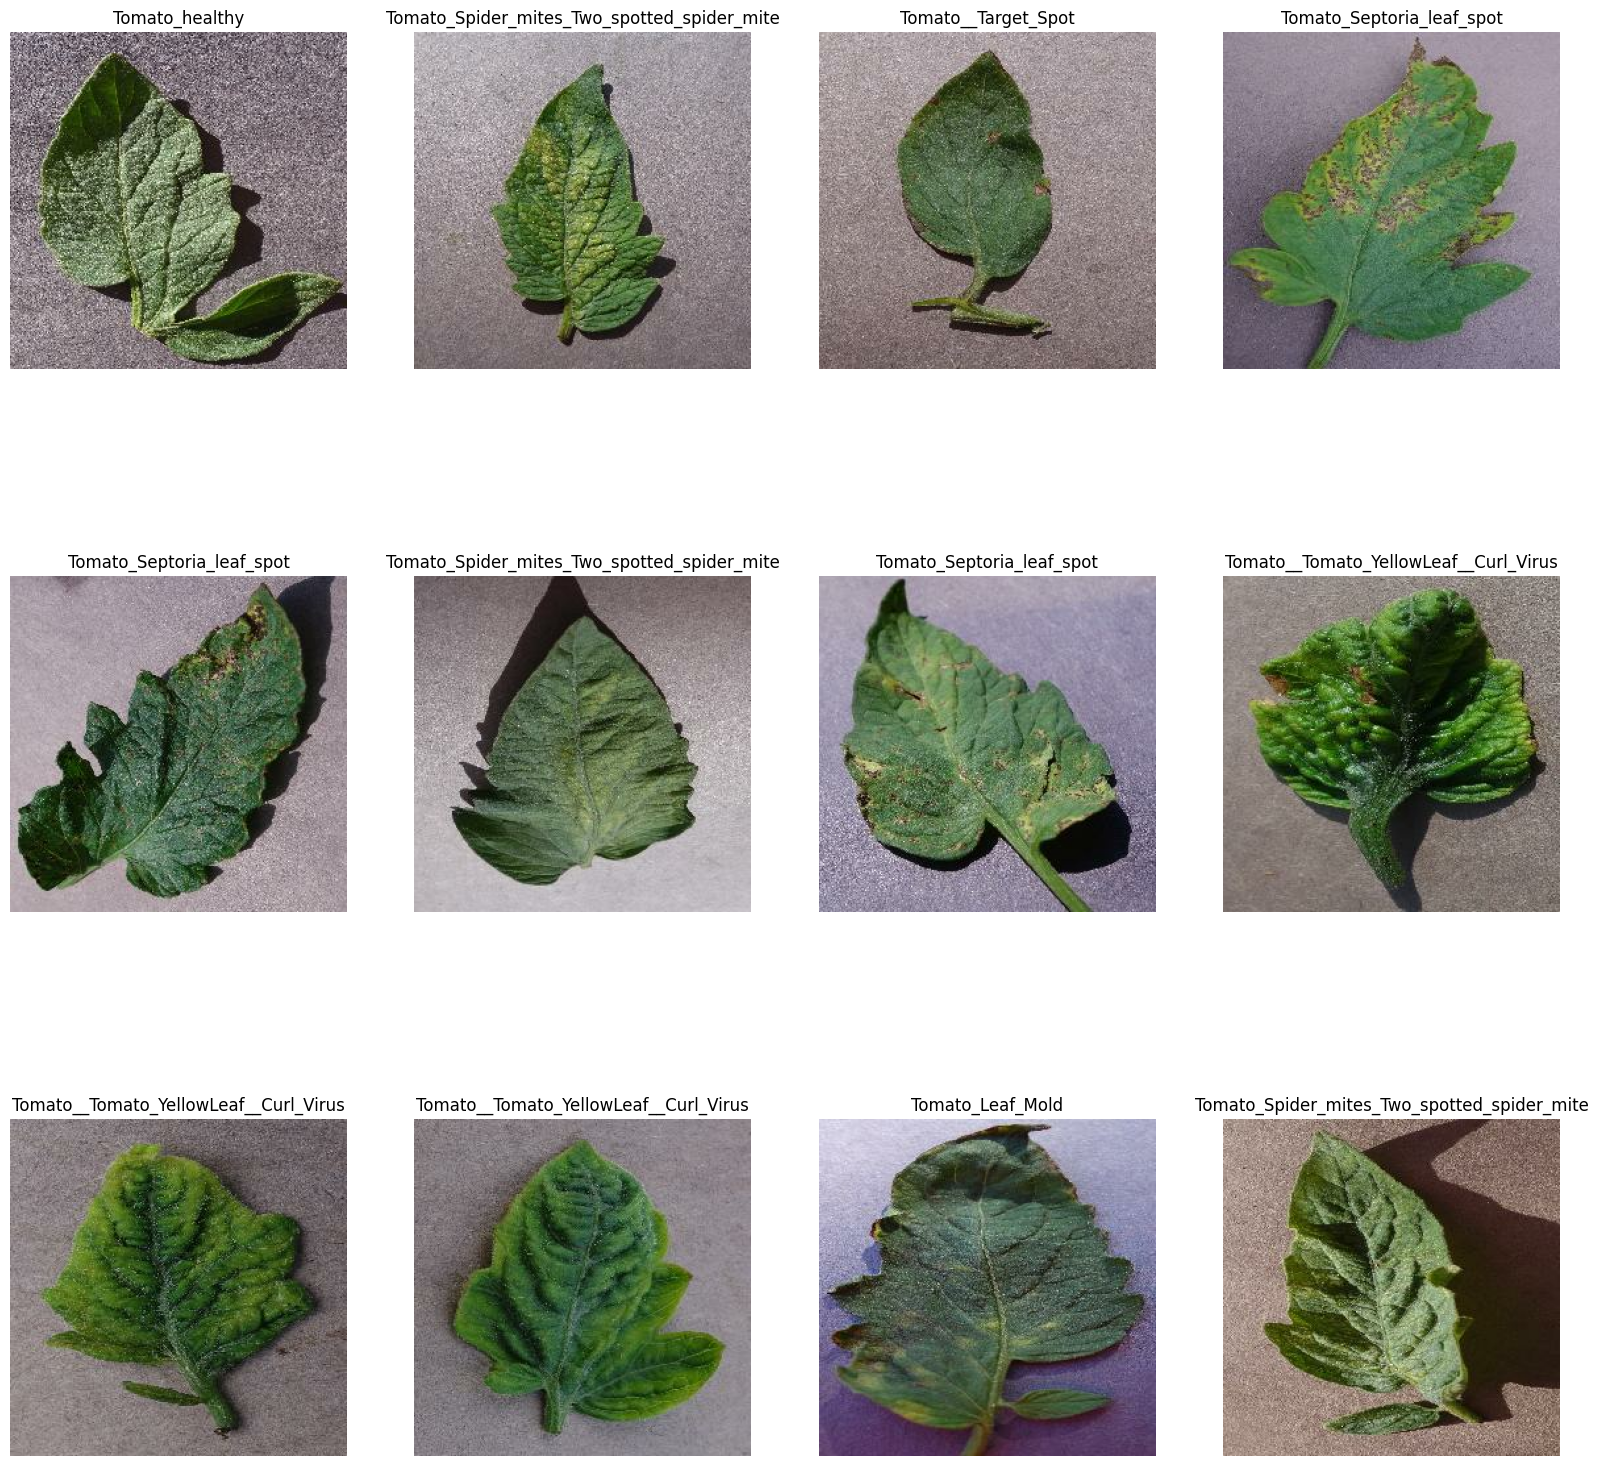

In [6]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def partitions(dataset,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True):
    if shuffle:
        dataset.shuffle(10000,seed=5)
    ds_size=len(dataset)
    train_size=int(ds_size*train_size)
    val_size=int(ds_size*val_size)
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [8]:
train_ds,test_ds,val_ds=partitions(dataset)

In [9]:
len(train_ds)

400

In [10]:
len(val_ds)

51

In [11]:
len(test_ds)

50

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(batch_size,image_size,image_size,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(9,activation='softmax')
])
model.build(input_shape=(batch_size,image_size,image_size,3))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    epochs=5,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5


2024-01-31 14:01:45.572799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 184 of 1000
2024-01-31 14:02:00.761626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - ETA: 0s - loss: 1.5514 - accuracy: 0.4408

2024-01-31 14:24:30.507896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:21: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-01-31 14:24:31.797406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


400/400 [==============================] - 1404s 3s/step - loss: 1.5514 - accuracy: 0.4408 - val_loss: 0.9971 - val_accuracy: 0.6282
Epoch 2/5
400/400 [==============================] - 985s 2s/step - loss: 0.8066 - accuracy: 0.7129 - val_loss: 1.2684 - val_accuracy: 0.6331
Epoch 3/5
400/400 [==============================] - 1355s 3s/step - loss: 0.5894 - accuracy: 0.7856 - val_loss: 0.8983 - val_accuracy: 0.7430
Epoch 4/5
400/400 [==============================] - 980s 2s/step - loss: 0.4497 - accuracy: 0.8401 - val_loss: 0.6381 - val_accuracy: 0.7945
Epoch 5/5
400/400 [==============================] - 1077s 3s/step - loss: 0.3888 - accuracy: 0.8605 - val_loss: 0.6421 - val_accuracy: 0.7995


In [19]:
model.evaluate(test_ds)

2024-01-31 15:40:20.700597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-01-31 15:40:25.398351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


50/50 [==============================] - 44s 524ms/step - loss: 0.6044 - accuracy: 0.7987


[0.6043900847434998, 0.7987499833106995]

first image to predict  :
actual label Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 1s 757ms/step
predicted label : Tomato_Spider_mites_Two_spotted_spider_mite


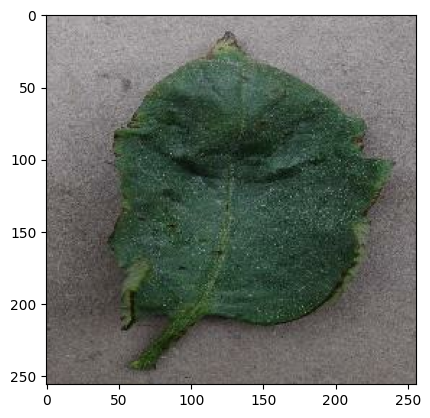

In [21]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print('first image to predict  :')
    plt.imshow(first_image),
    print('actual label',class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print('predicted label :',class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model,image):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 37ms/step


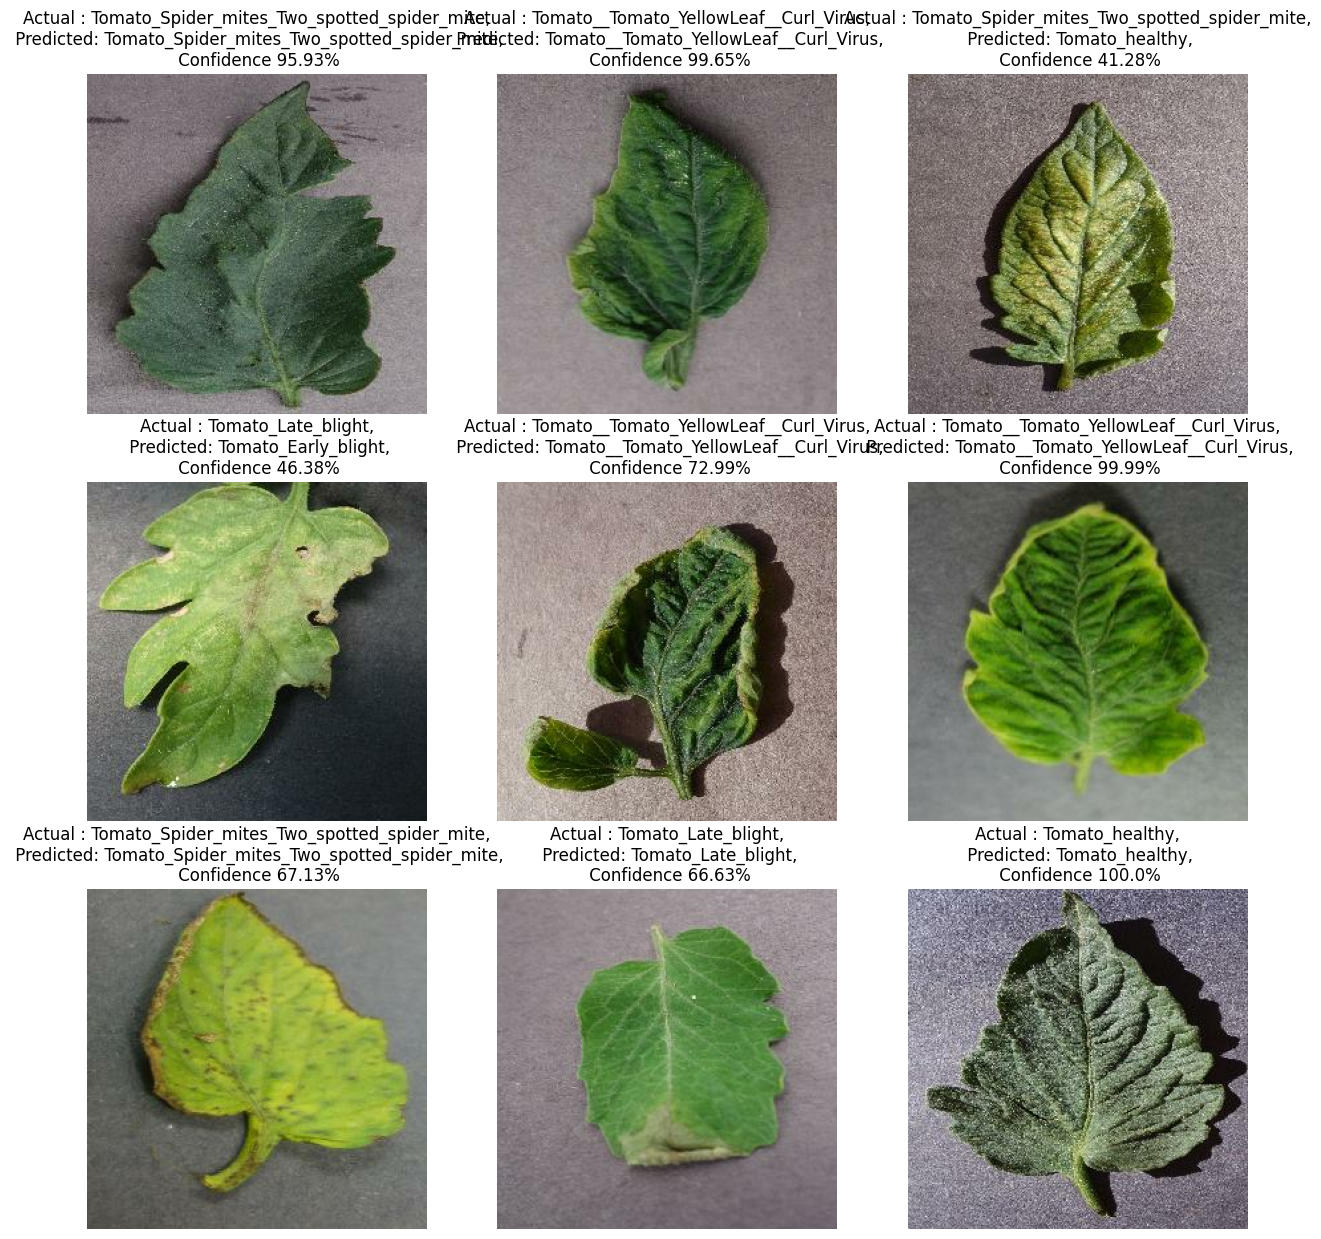

In [23]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class},\n Confidence {confidence}%")
        plt.axis("off")

In [24]:
model_version = 1
model.save(f"model_{model_version}")

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets
